In [1]:
# necessary as we will be simulating trajectories in parallel later in notebook
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
from helpers.shared_imports import *
%matplotlib inline

In [16]:
from helpers.integrate import Controller, simulate_system_odeint, d_state_bebop, mass_bebop, simulate_system_multiple, get_unbiased_controller
from helpers.vis import trajectory_plot_compare
from helpers.optimality_eval import get_equilibrium

**Numerical integration of bebop dynamics with neural network control**

We compare a neural network trajectory with its equivalent optimal trajectory from the dataset.

Numerical integration is done using `scipy.integrate.odeint`

In [4]:
pkl_name = 'power_bebop_h04_n0100.pkl'

model_path = 'models_pickled/bebop_power/'
nn_controller = Controller(path_to_pickle=os.path.join(model_path, pkl_name))

In [5]:
data_path = 'datasets/bebop_power.npy'
dataset = np.load(data_path)

In [12]:
state_idx = {'time':0, 'x':1, 'vx':2, 'z':3, 'vz':4, 'theta':5, 'u1':6, 'u2':7}
state_indices = [1,2,3,4,5]

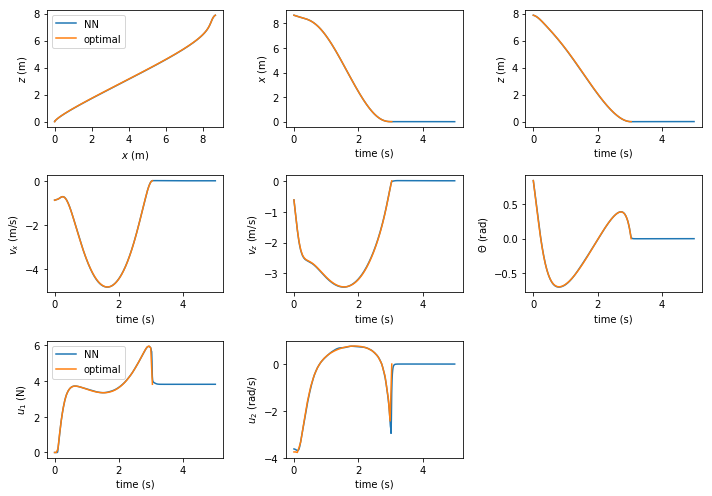

In [7]:
traj_idx = 2
traj_optimal = dataset[traj_idx]
initial_state = traj_optimal[0, state_indices]

traj_sim = simulate_system_odeint(nn_controller, \
                                  d_state_bebop, \
                                  initial_state, \
                                  mass=mass_bebop, \
                                  dt=0.01, \
                                  max_time=5.0)
trajectory_plot_compare(traj_optimal, traj_sim, label1='optimal', label2='NN')
plt.show()

**Simulate multiple trajectories in parallel**

We take 100 initial conditions from the dataset and simulate all for a fixed time (20 seconds).
This ensures the system has converged for all runs.

We then compute the mean and standard deviation of the final state.
We observe that for a majority of the trained nets, the system converges to the same state regardless of initial condition.
This is indicated by the small standard deviation.

In [10]:
%%time
n_traj = 100
initial_states = dataset[:n_traj, 0, state_indices]

traj_sims = simulate_system_multiple(
                nn_controller, \
                d_state_bebop, \
                initial_states, \
                mass=mass_bebop, \
                max_time=20, \
                n_jobs=40)  # number of CPUs to use

CPU times: user 337 ms, sys: 444 ms, total: 781 ms
Wall time: 7.64 s


In [13]:
final_state_mean = np.mean(traj_sims[:,-1,:], axis=0)
final_state_std = np.std(traj_sims[:,-1,:].astype(np.float64), axis=0)

which_vars = ['x', 'z', 'vx', 'vz', 'theta', 'u1', 'u2']
indices = [state_idx[key] for key in which_vars]

print('mean :', ['{:.3e}'.format(x) for x in final_state_mean[indices]])
print('std  :', ['{:.3e}'.format(x) for x in final_state_std[indices]])

mean : ['-7.290e-03', '8.844e-03', '-4.196e-09', '2.273e-09', '3.287e-10', '3.817e+00', '-2.838e-08']
std  : ['5.721e-09', '2.893e-09', '7.456e-09', '6.452e-09', '2.231e-09', '4.067e-08', '1.778e-07']


**Determine convergence state of system with neural network (accurately)**

This is also called the *equilibrium point*.

Find $x_e$ s.t. $f(x_e, N(x_e)) = 0$

We do this using `pygmo`.

Note how the state in x and z are close in value to the above mean.

In [15]:
equ_point = get_equilibrium(nn_controller)
equ_point

array([-0.00729047,  0.        ,  0.00884396,  0.        ,  0.        ])

Since the equilibrium point is very close to the target state (order of $10^{-3}$), we can view this as a bias and add this to the state when evaluating the control.

Now the controls at the target are the equilibrium controls: [mg, 0]

In [27]:
nn_controller_ub = get_unbiased_controller(nn_controller, equ_point)
print('control at x=0:     ', nn_controller_ub.compute_control([0,0,0,0,0]))
print('equilibrium control:', [mass_bebop*9.81, 0])

control at x=0:      [3.81658050e+00 5.16730755e-16]
equilibrium control: [3.8165805, 0]
